<a href="https://colab.research.google.com/github/kmrasmussen/cell_project/blob/main/Section_5_1_INSCT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import umap
from sklearn.decomposition import PCA

In [ ]:
X = np.load('/content/gdrive/My Drive/uni_archive/cell_proj/experiments/experiment_outputs/simulated_gauss1_difficult1.npy')
y = np.load('/content/gdrive/My Drive/uni_archive/cell_proj/experiments/experiment_outputs/simulated_gauss1_labels_difficult1.npy')
y2 = np.load('/content/gdrive/My Drive/uni_archive/cell_proj/experiments/experiment_outputs/simulated_gauss1_labels2_difficult1.npy')

In [ ]:
y2.take(np.arange(6995, 7005))

array([1, 2, 1, 2, 2, 3, 4, 3, 5, 5])

In [ ]:
y2[6995:7005]

array([1, 2, 1, 2, 2, 3, 4, 3, 5, 5])

In [ ]:
batch1 = X[0:7000]
batch1_y2 = y2[0:7000]

In [ ]:
batch2 = X[7000:]
batch2_y2 = y2[7000:]

In [ ]:
k = 5
b1_nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(batch1)
b2_nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(batch2)
both_batches_nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(X)

In [ ]:
_, indices_knearest_b2_in_b1 = b1_nbrs.kneighbors(batch2)
_, indices_knearest_b1_in_b2 = b2_nbrs.kneighbors(batch1)

In [ ]:
def find_mnns(knearest_in_batch_2, knearest_in_batch_1):
    mnns = []
    # Go through each cell in batch 1 where you know its NN in batch 2
    for i in range(knearest_in_batch_2.shape[0]):
        # Select the batch 2 NNs for that batch 1 cell
        knearest_a = knearest_in_batch_2[i,:]
        # Go through all its NNs
        for j in knearest_a:
            # Does the NN in batch 2 also have this batch 1 cell as one of its NNs?
            if i in knearest_in_batch_1[j,:]:
                #i_vec = batch_1_with_effect[i,:]
                #j_vec = batch_2_with_effect[j,:]
                #cos_dist = distance.cosine(i_vec, j_vec)
                mnns.append((i,j))
    return mnns

In [ ]:
all_mnns = find_mnns(indices_knearest_b1_in_b2, indices_knearest_b2_in_b1)

In [ ]:
batch2_mnn_dict = {}
batch1_mnn_dict = {}
for batch1_cell, batch2_cell in all_mnns:
  if batch2_cell in batch2_mnn_dict:
    batch2_mnn_dict[batch2_cell].append(batch1_cell)
  else:
    batch2_mnn_dict[batch2_cell] = [batch1_cell]
  
  if batch1_cell in batch1_mnn_dict:
    batch1_mnn_dict[batch1_cell].append(batch2_cell)
  else:
    batch1_mnn_dict[batch1_cell] = [batch2_cell]

In [ ]:
class TripletCellDataset(Dataset):
  def __init__(self, both_batches, batch1, batch2, batch1_mnn_dict, batch2_mnn_dict, positive_sample_mode = 'other'):
    assert positive_sample_mode == 'other' or positive_sample_mode == 'all'
    self.X = both_batches
    self.b1 = batch1
    self.b2 = batch2
    self.b1_mnns = batch1_mnn_dict
    self.b2_mnns = batch2_mnn_dict
    self.positive_sample_mode = positive_sample_mode
    
  def __len__(self):
    return self.b1.shape[0] + self.b2.shape[0]

  def __getitem__(self, idx):
    batch_number = None
    anchor_batch = None
    anchor_id = None
    anchor = None
    positive_id = None
    positive = None
    negative_id = None
    negative = None
    if idx < self.b1.shape[0]:
      batch_number = 1
      anchor_batch = self.b1
      anchor_id = idx
      anchor = self.b1[anchor_id]
      if anchor_id in self.b1_mnns:
        anchor_mnns = np.array(self.b1_mnns[anchor_id])
        #print('Yay', anchor_id, ' in B1 has mnns', anchor_mnns)
        #print('labels', batch2_y2.take(anchor_mnns))
        #print('Anchor label', batch1_y2[anchor_id])
        positive_id = np.random.choice(anchor_mnns)
        positive = self.b2[positive_id]
      else:
        #print('Oops', anchor_id, ' in B1 does not have mnns')
        if self.positive_sample_mode == 'all':
          _, indices = both_batches_nbrs.kneighbors(batch1[anchor_id:anchor_id + 1])
          #print('K nearest in B2 to anchor', anchor_id, ' in B1', indices)
          positive_id = np.random.choice(indices[0])
          positive = self.X[positive_id]
        elif self.positive_sample_mode == 'other':
          _, indices = b2_nbrs.kneighbors(batch1[anchor_id:anchor_id + 1])
          positive_id = np.random.choice(indices[0])
          positive = self.b2[positive_id]
      #print('Positive id', positive_id)
      negative_id = np.random.randint(self.b1.shape[0])
      negative = self.b1[negative_id]
      #print('Choosing negative randomly', negative_id)
    else:
      batch_number = 2
      anchor_batch = self.b2
      anchor_id = idx - self.b1.shape[0]
      anchor = self.b2[anchor_id]
      if anchor_id in self.b2_mnns:
        anchor_mnns = np.array(self.b2_mnns[anchor_id])
        #print('Yay', anchor_id, ' in B2 has mnns', anchor_mnns, 'labels', batch1_y2.take(anchor_mnns))
        #print('Anchor label', batch2_y2[anchor_id])
        positive_id = np.random.choice(anchor_mnns)
        positive = self.b1[positive_id]
      else:
        if self.positive_sample_mode == 'all':
          #print('Oops', anchor_id, ' in B2 does not have mnns')
          _, indices = both_batches_nbrs.kneighbors(batch2[anchor_id:anchor_id + 1])
          #print('K nearest in B1 to anchor', anchor_id, ' in B2', indices)
          positive_id = np.random.choice(indices[0])
          positive = self.X[positive_id]
        elif self.positive_sample_mode == 'other':
          _, indices = b1_nbrs.kneighbors(batch2[anchor_id:anchor_id + 1])
          positive_id = np.random.choice(indices[0])
          positive = self.b1[positive_id]
      #print('Positive id', positive_id)
      negative_id = np.random.randint(self.b2.shape[0])
      negative = self.b2[negative_id]
      #print('Choosing negative randomly', negative_id)
    # batch_number, anchor_id, anchor, positive_id, positive, negative_id, negative
    return anchor, positive, negative

In [ ]:
sim_dataset = TripletCellDataset(X, batch1, batch2, batch1_mnn_dict, batch2_mnn_dict, positive_sample_mode='all')

In [ ]:
dataloader = DataLoader(sim_dataset, shuffle=False, batch_size=16)

In [ ]:
class TripletNet(nn.Module):
  def __init__(self, input_dim, hidden_dim, rep_dim):
    super().__init__()
    self.dense1 = nn.Linear(in_features = input_dim, out_features = hidden_dim)
    self.dense2 = nn.Linear(in_features = hidden_dim, out_features = rep_dim)
  def forward(self, x):
    x = F.relu(self.dense1(x))
    x = self.dense2(x)
    return x

In [ ]:
net = TripletNet(500, 100, 20)
pairwise_dist = nn.PairwiseDistance(p = 2.)
margin_hyperparam = 0.
optimizer = optim.Adam(net.parameters())

for epoch_i in range(2):
  print('')
  print('Epoch', epoch_i)

  running_loss = 0.
  for i, data in enumerate(dataloader):
    anchor, positive, negative = data

    optimizer.zero_grad()

    anchor_embed = net(anchor.float())
    positive_embed = net(positive.float())
    negative_embed = net(negative.float())

    ap_dists = pairwise_dist(anchor_embed, positive_embed)
    an_dists = pairwise_dist(anchor_embed, negative_embed)
    pn_dists = pairwise_dist(negative_embed, positive_embed)
    losses = ap_dists - torch.min(an_dists, pn_dists) + margin_hyperparam
    loss = losses.sum()

    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    if i % 100 == 99:
      print('Running loss', running_loss / 100)
      running_loss = 0.


Epoch 0
Running loss -143186039.34328124
Running loss -1147705324.48
Running loss -3524236038.4
Running loss -8113721896.96
Running loss -12461834685.44
Running loss -17825909176.32

Epoch 1
Running loss -27825119252.48
Running loss -36612621045.76
Running loss -46282478100.48
Running loss -60350736250.88
Running loss -67834101309.44
Running loss -81689939476.48


In [ ]:
X_encoded = net(torch.tensor(X).float())

In [ ]:
X_encoded.shape

torch.Size([10000, 20])

In [ ]:
pca = PCA(n_components=2)
X_encoded_pca = pca.fit_transform(X_encoded.detach())

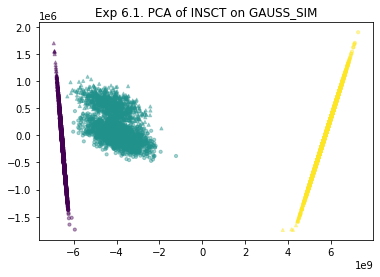

In [ ]:
plt.title('Exp 6.1. PCA of INSCT on GAUSS_SIM')
plt.scatter(X_encoded_pca[:7000][:,0], X_encoded_pca[:7000][:,1], c=y2[:7000], marker='o', s=10, alpha=0.4)
plt.scatter(X_encoded_pca[7000:][:,0], X_encoded_pca[7000:][:,1], c=y2[7000:], marker='^', s=10, alpha=0.4)
plt.savefig('/content/gdrive/My Drive/uni_archive/cell_proj/experiments/experiment_plots/exp.6.1.insct_gauss_sim_pca.png')
#plt.scatter(X_encoded_pca[:,0] + 5, X_encoded_pca[:,1] + 5, c=y2)

In [ ]:
reducer = umap.UMAP()
X_encoded_umap = reducer.fit_transform(X_encoded.detach())

In [ ]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, random_state=0).fit(X_encoded_umap)

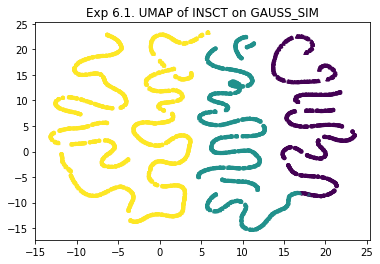

In [ ]:
plt.title('Exp 6.1. UMAP of INSCT on GAUSS_SIM')
plt.scatter(X_encoded_umap[:7000][:,0], X_encoded_umap[:7000][:,1], c=y2[:7000], marker='o', s=10, alpha=0.4)
plt.scatter(X_encoded_umap[7000:][:,0], X_encoded_umap[7000:][:,1], c=y2[7000:], marker='^', s=10, alpha=0.4)
plt.savefig('/content/gdrive/My Drive/uni_archive/cell_proj/experiments/experiment_plots/exp.6.1.insct_gauss_sim_umap.png')